In [1]:
# ! pip install scikit-lego

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import re
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn import feature_selection
from sklearn import decomposition
from sklearn import manifold
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn import ensemble
import sklearn.metrics as skmetric

from sklego.meta import EstimatorTransformer
from sklego.preprocessing import ColumnSelector, ColumnDropper

import xgboost

from IPython.display import display, clear_output

In [4]:
sns.set()

In [5]:
INPUT_PATH = '../input/'

In [6]:
df_files = []
for f in os.listdir(INPUT_PATH):
    df_files.append(f)

df_files

['train.csv',
 'alldata_transform.csv',
 'df_pipe11.csv',
 'df_pipe9.csv',
 'test.csv',
 'pred_Lasso.csv',
 'pred_SVR.csv',
 'df_pipe5.csv',
 'df_pipe2.csv',
 'df_pipe4.csv',
 'pred_AdaBoostRegressor.csv',
 'df_pipe3.csv',
 'df_pipe10.csv',
 'df_pipe8.csv',
 'pred_LinearRegression.csv',
 'pred_ExtraTreesRegressor.csv',
 'train_folds.csv',
 'df_pipe6.csv',
 'pred_Ridge.csv',
 'df_pipe7.csv',
 'leaderboard.csv',
 'raw.csv',
 'pred_RandomForestRegressor.csv',
 'pred_GradientBoostingRegressor.csv',
 'mpg_clean.csv',
 'df_pipe1.csv']

In [7]:
df = pd.read_csv(INPUT_PATH + 'mpg_clean.csv')
df.tail()

,target,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
387,27.0,4,140.0,86.0,2790,15.6,82,usa,ford mustang gl
388,44.0,4,97.0,52.0,2130,24.6,82,europe,vw pickup
389,32.0,4,135.0,84.0,2295,11.6,82,usa,dodge rampage
390,28.0,4,120.0,79.0,2625,18.6,82,usa,ford ranger
391,31.0,4,119.0,82.0,2720,19.4,82,usa,chevy s-10


In [8]:
# remove extra spaces if any
for col in ['origin', 'name']:
    df[col] = df[col].apply(lambda x: ' '.join(x.split()))

# extract car company from `name`
df['car_company'] = df['name'].apply(lambda x: x.split()[0])
df.drop('name', axis=1, inplace=True)
df.tail()

,target,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_company
387,27.0,4,140.0,86.0,2790,15.6,82,usa,ford
388,44.0,4,97.0,52.0,2130,24.6,82,europe,vw
389,32.0,4,135.0,84.0,2295,11.6,82,usa,dodge
390,28.0,4,120.0,79.0,2625,18.6,82,usa,ford
391,31.0,4,119.0,82.0,2720,19.4,82,usa,chevy


In [9]:
df_ = pd.DataFrame()

columns = ['origin', 'cylinders']
prefixes = ['origin', 'cylinders']

for pref, col in zip(prefixes, columns):
    df_ = pd.concat((df_, pd.get_dummies(df[col], prefix=pref)), axis=1)
    
df_.head()

,origin_europe,origin_japan,origin_usa,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8
0,0,0,1,0,0,0,0,1
1,0,0,1,0,0,0,0,1
2,0,0,1,0,0,0,0,1
3,0,0,1,0,0,0,0,1
4,0,0,1,0,0,0,0,1


In [10]:
df = pd.concat((pd.get_dummies(df['origin'], prefix='origin'), df), axis=1)
df.drop('origin', axis=1, inplace=True)
df.head()

,origin_europe,origin_japan,origin_usa,target,cylinders,displacement,horsepower,weight,acceleration,model_year,car_company
0,0,0,1,18.0,8,307.0,130.0,3504,12.0,70,chevrolet
1,0,0,1,15.0,8,350.0,165.0,3693,11.5,70,buick
2,0,0,1,18.0,8,318.0,150.0,3436,11.0,70,plymouth
3,0,0,1,16.0,8,304.0,150.0,3433,12.0,70,amc
4,0,0,1,17.0,8,302.0,140.0,3449,10.5,70,ford


In [11]:
df.model_year.value_counts().sort_index()

70    29
71    27
72    28
73    40
74    26
75    30
76    34
77    28
78    36
79    29
80    27
81    28
82    30
Name: model_year, dtype: int64

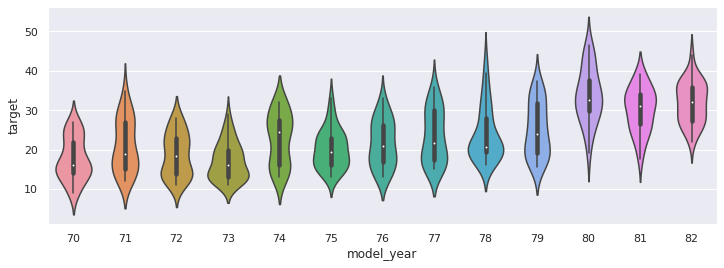

In [12]:
pyplot.figure(1,(12,4))
sns.violinplot(x='model_year', y='target', data=df)
pyplot.show()

In [13]:
df.model_year.value_counts(bins=4).sort_index()

(69.987, 73.0]    124
(73.0, 76.0]       90
(76.0, 79.0]       93
(79.0, 82.0]       85
Name: model_year, dtype: int64

In [14]:
df = pd.concat((pd.get_dummies(pd.cut(df.model_year, bins=4, precision=1), prefix='yr'), df), axis=1)
df.drop('model_year', axis=1, inplace=True)
df.head()

,"yr_(70.0, 73.0]","yr_(73.0, 76.0]","yr_(76.0, 79.0]","yr_(79.0, 82.0]",origin_europe,origin_japan,origin_usa,target,cylinders,displacement,horsepower,weight,acceleration,car_company
0,1,0,0,0,0,0,1,18.0,8,307.0,130.0,3504,12.0,chevrolet
1,1,0,0,0,0,0,1,15.0,8,350.0,165.0,3693,11.5,buick
2,1,0,0,0,0,0,1,18.0,8,318.0,150.0,3436,11.0,plymouth
3,1,0,0,0,0,0,1,16.0,8,304.0,150.0,3433,12.0,amc
4,1,0,0,0,0,0,1,17.0,8,302.0,140.0,3449,10.5,ford


In [15]:
df.car_company.unique()

array(['chevrolet', 'buick', 'plymouth', 'amc', 'ford', 'pontiac',
       'dodge', 'toyota', 'datsun', 'volkswagen', 'peugeot', 'audi',
       'saab', 'bmw', 'chevy', 'hi', 'mercury', 'opel', 'fiat',
       'oldsmobile', 'chrysler', 'mazda', 'volvo', 'renault', 'toyouta',
       'maxda', 'honda', 'subaru', 'chevroelt', 'capri', 'vw',
       'mercedes-benz', 'cadillac', 'mercedes', 'vokswagen', 'triumph',
       'nissan'], dtype=object)

**Check for spelling mistakes**

In [16]:
def most_similar(pattern, docs, ignore_case=True):
    if ignore_case:
        pattern = pattern.lower()

    pattern_len = len(pattern)
    similarity_score = {}
    count = 1

    for doc in docs:

        if ignore_case:
            doc = doc.lower()

        if pattern == doc:
            similarity_score[doc] = 1.0
            count += 1
            continue

        doc_len = len(doc)

        cache_table = np.empty(shape=(doc_len+1, pattern_len+1))
        cache_table[0][0] = 0

        space_penalty = 1

        for j in range(1, pattern_len+1):
            cache_table[0][j] = space_penalty*j

        for i in range(1, doc_len+1):
            cache_table[i][0] = space_penalty*i

        for i in range(1, doc_len+1):

            for j in range(1, pattern_len+1):

                miss_penalty = cache_table[i-1][j-1]

                if pattern[j-1] != doc[i-1]:
                    miss_penalty += 1

                cache_table[i][j] = min([space_penalty+cache_table[i-1][j],
                                         space_penalty+cache_table[i][j-1],
                                         miss_penalty])

        lev_dist = cache_table[doc_len][pattern_len]
        similarity_score[doc] = (pattern_len + doc_len -
                                                lev_dist) / (pattern_len + doc_len)
        count += 1

    return sorted(similarity_score.items(), key=lambda kv: kv[1])[-2]

In [17]:
car_companies = list(df.car_company.unique())
for name in car_companies:
    print(name, most_similar(name, car_companies)[0])

chevrolet chevroelt
buick fiat
plymouth toyouta
amc bmw
ford honda
pontiac honda
dodge honda
toyota toyouta
datsun nissan
volkswagen vokswagen
peugeot renault
audi capri
saab fiat
bmw amc
chevy chevroelt
hi vw
mercury mercedes
opel capri
fiat saab
oldsmobile plymouth
chrysler chevrolet
mazda maxda
volvo honda
renault mercury
toyouta toyota
maxda mazda
honda maxda
subaru saab
chevroelt chevrolet
capri audi
vw bmw
mercedes-benz mercedes
cadillac chrysler
mercedes mercedes-benz
vokswagen volkswagen
triumph toyouta
nissan datsun


In [18]:
df.car_company.nunique()

37

In [19]:
# correcting spelling mistakes
name_mapper = {
    'chevroelt': 'chevrolet',
    'toyouta': 'toyota',
    'vokswagen': 'volkswagen',
    'mercedes-benz': 'mercedes',
    'maxda': 'mazda'
}
df['car_company'] = df.car_company.apply(lambda x: name_mapper[x] if x in name_mapper.keys() else x)
df.car_company.nunique()

32

In [20]:
df.tail()

,"yr_(70.0, 73.0]","yr_(73.0, 76.0]","yr_(76.0, 79.0]","yr_(79.0, 82.0]",origin_europe,origin_japan,origin_usa,target,cylinders,displacement,horsepower,weight,acceleration,car_company
387,0,0,0,1,0,0,1,27.0,4,140.0,86.0,2790,15.6,ford
388,0,0,0,1,1,0,0,44.0,4,97.0,52.0,2130,24.6,vw
389,0,0,0,1,0,0,1,32.0,4,135.0,84.0,2295,11.6,dodge
390,0,0,0,1,0,0,1,28.0,4,120.0,79.0,2625,18.6,ford
391,0,0,0,1,0,0,1,31.0,4,119.0,82.0,2720,19.4,chevy


In [21]:
company_count = df.car_company.value_counts()
top_companies = company_count[company_count>=10].index
top_companies

Index(['ford', 'chevrolet', 'plymouth', 'dodge', 'amc', 'toyota', 'datsun',
       'buick', 'pontiac', 'volkswagen', 'honda', 'mazda', 'mercury',
       'oldsmobile'],
      dtype='object')

In [22]:
print(*set(df.car_company.unique()).difference(top_companies))

chrysler triumph mercedes opel saab nissan volvo renault chevy capri audi hi peugeot subaru vw fiat cadillac bmw


In [23]:
df['car_company'] = df.car_company.apply(lambda x: 'rare_company' if x not in top_companies else x)
df = pd.concat((pd.get_dummies(df.car_company), df), axis=1)
df.drop('car_company', axis=1, inplace=True)
df.tail()

,amc,buick,chevrolet,datsun,dodge,ford,honda,mazda,mercury,oldsmobile,...,"yr_(79.0, 82.0]",origin_europe,origin_japan,origin_usa,target,cylinders,displacement,horsepower,weight,acceleration
387,0,0,0,0,0,1,0,0,0,0,...,1,0,0,1,27.0,4,140.0,86.0,2790,15.6
388,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,44.0,4,97.0,52.0,2130,24.6
389,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,32.0,4,135.0,84.0,2295,11.6
390,0,0,0,0,0,1,0,0,0,0,...,1,0,0,1,28.0,4,120.0,79.0,2625,18.6
391,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,31.0,4,119.0,82.0,2720,19.4


In [24]:
df.cylinders.value_counts()

4    199
8    103
6     83
3      4
5      3
Name: cylinders, dtype: int64

In [25]:
df['cylinders'] = df.cylinders.apply(lambda x: 'rare' if x in [3, 5] else x)
df = pd.concat((pd.get_dummies(df.cylinders, prefix='cylinders'), df), axis=1)
df.drop('cylinders', axis=1, inplace=True)
df.tail()

,cylinders_4,cylinders_6,cylinders_8,cylinders_rare,amc,buick,chevrolet,datsun,dodge,ford,...,"yr_(76.0, 79.0]","yr_(79.0, 82.0]",origin_europe,origin_japan,origin_usa,target,displacement,horsepower,weight,acceleration
387,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,1,27.0,140.0,86.0,2790,15.6
388,1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,44.0,97.0,52.0,2130,24.6
389,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,32.0,135.0,84.0,2295,11.6
390,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,1,28.0,120.0,79.0,2625,18.6
391,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,31.0,119.0,82.0,2720,19.4


In [26]:
df = pd.concat((df.loc[:, 'origin_europe':'origin_usa'],
                df.loc[:, 'yr_(70.0, 73.0]':'yr_(79.0, 82.0]'],
                df.loc[:, 'cylinders_4': 'cylinders_rare'],
                df.loc[:, 'amc': 'volkswagen'],
                df.loc[:, 'displacement':],
                df.loc[:, 'target']), axis=1)
df.tail()

,origin_europe,origin_japan,origin_usa,"yr_(70.0, 73.0]","yr_(73.0, 76.0]","yr_(76.0, 79.0]","yr_(79.0, 82.0]",cylinders_4,cylinders_6,cylinders_8,...,plymouth,pontiac,rare_company,toyota,volkswagen,displacement,horsepower,weight,acceleration,target
387,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,140.0,86.0,2790,15.6,27.0
388,1,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,97.0,52.0,2130,24.6,44.0
389,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,135.0,84.0,2295,11.6,32.0
390,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,120.0,79.0,2625,18.6,28.0
391,0,0,1,0,0,0,1,1,0,0,...,0,0,1,0,0,119.0,82.0,2720,19.4,31.0


In [27]:
regex = re.compile(r"\[|\]|\(|\)|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<')))
                          else col for col in df.columns.values]
df.tail()

,origin_europe,origin_japan,origin_usa,"yr__70.0, 73.0_","yr__73.0, 76.0_","yr__76.0, 79.0_","yr__79.0, 82.0_",cylinders_4,cylinders_6,cylinders_8,...,plymouth,pontiac,rare_company,toyota,volkswagen,displacement,horsepower,weight,acceleration,target
387,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,140.0,86.0,2790,15.6,27.0
388,1,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,97.0,52.0,2130,24.6,44.0
389,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,135.0,84.0,2295,11.6,32.0
390,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,120.0,79.0,2625,18.6,28.0
391,0,0,1,0,0,0,1,1,0,0,...,0,0,1,0,0,119.0,82.0,2720,19.4,31.0


In [28]:
rng = np.random.seed(42)

In [29]:
df_train, df_test = model_selection.train_test_split(df, train_size=0.75, shuffle= True, random_state=rng)
df_train.shape, df_test.shape

((294, 31), (98, 31))

In [30]:
# All estimators under consideration

knn = neighbors.KNeighborsRegressor(n_neighbors=7, n_jobs=-1)

lin_reg = linear_model.LinearRegression(n_jobs=-1)

ridge_reg = linear_model.RidgeCV()

lasso_reg = linear_model.LassoCV(
    max_iter=10000,
    random_state=rng
)

baseyian_ridge = linear_model.BayesianRidge(n_iter=1000,)

lars = linear_model.LarsCV(max_iter=1000, n_jobs=-1)

svr = svm.SVR()

random_forest = ensemble.RandomForestRegressor(
    n_estimators=150,
    max_depth = 5,
    min_samples_split=8,
    n_jobs=-1,
    random_state=rng
)

extra_trees = ensemble.ExtraTreesRegressor(
    n_estimators=150,
    max_depth = 5,
    min_samples_split=8,
    n_jobs=-1,
    random_state=rng
)

adaboost = ensemble.AdaBoostRegressor(
    n_estimators=150,
    random_state=rng
)

gradboost = ensemble.GradientBoostingRegressor(
    n_estimators=150,
    max_depth = 5,
    min_samples_split=8,
    random_state=rng
)

all_estimators = ['knn', 'lin_reg', 'ridgecv', 'lassocv', 'baseyian_ridge', 'larscv', 'svr',
                  'random_forest', 'extra_trees', 'adaboost', 'gradboost', ]

In [31]:
continous_cols = list(df.loc[:, 'displacement':'acceleration'].columns)
continous_cols

['displacement', 'horsepower', 'weight', 'acceleration']

In [32]:
categorical_cols = list(set(df.columns).difference(continous_cols))
categorical_cols.remove('target')
print(*categorical_cols)

yr__76.0, 79.0_ plymouth cylinders_6 amc volkswagen origin_japan chevrolet cylinders_4 cylinders_rare yr__73.0, 76.0_ cylinders_8 datsun ford origin_usa mazda dodge mercury oldsmobile rare_company honda toyota origin_europe buick pontiac yr__79.0, 82.0_ yr__70.0, 73.0_


In [33]:
cont_cols_selector = ColumnSelector(continous_cols) 

cat_cols_selector = ColumnSelector(categorical_cols) 

cont_cols_scaler = ColumnTransformer([
    ('robust_scale', preprocessing.RobustScaler(), ['horsepower', 'acceleration']),
    ('std_scaler', preprocessing.StandardScaler(), ['displacement', 'weight']),
], remainder="passthrough")

cat_cols_scaler = ColumnTransformer([
    ('std_scaler', preprocessing.StandardScaler(), categorical_cols),
], remainder="passthrough")

all_cols_scaler = ColumnTransformer([
    ('robust_scale', preprocessing.RobustScaler(), ['horsepower', 'acceleration']),
    ('std_scale_cont', preprocessing.StandardScaler(), ['displacement', 'weight']),
    ('std_scale_cat', preprocessing.StandardScaler(), categorical_cols),
], remainder="passthrough")

estimator = Pipeline([
        ("estimator", FeatureUnion([
            ("knn",  EstimatorTransformer(knn)),
            ("lin_reg",  EstimatorTransformer(lin_reg)),
            ("ridgecv",  EstimatorTransformer(ridge_reg)),
            ("lassocv",  EstimatorTransformer(lasso_reg)),
            ("baseyian_ridge",  EstimatorTransformer(baseyian_ridge)),
            ("larscv",  EstimatorTransformer(lars)),
            ("svr", EstimatorTransformer(svr)),
            ("random_forest", EstimatorTransformer(random_forest)),
            ("extra_trees", EstimatorTransformer(extra_trees)),
            ("adaboost", EstimatorTransformer(adaboost)),
            ("gradboost", EstimatorTransformer(gradboost)),
    ], n_jobs=-1))
])

In [34]:
pipe_1 = Pipeline([
    ('grab_cols', cont_cols_selector),
    ('scale_cols', cont_cols_scaler),
    ('fit_estimator', estimator)
])

pipe_2 = Pipeline([
    ('grab_cols', cat_cols_selector),
    ('fit_estimator', estimator)
])

pipe_3 = Pipeline([
    ('grab_cols', cat_cols_selector),
    ('scale_cols', cat_cols_scaler),
    ('fit_estimator', estimator)
])

pipe_4 = Pipeline([
    ('scale_cols', all_cols_scaler),
    ('fit_estimator', estimator)
])

pipe_5 = Pipeline([
    ('scale_cols', all_cols_scaler),
    ('select_kbest', feature_selection.SelectKBest(k=2)),
    ('fit_estimator', estimator),
])

pipe_6 = Pipeline([
    ('scale_cols', all_cols_scaler),
    ('select_kbest', feature_selection.SelectKBest(k=4)),
    ('fit_estimator', estimator),
])

pipe_7 = Pipeline([
    ('scale_cols', all_cols_scaler),
    ('select_kbest', feature_selection.SelectKBest(k=8)),
    ('fit_estimator', estimator),
])

pipe_8 = Pipeline([
    ('scale_cols', all_cols_scaler),
    ('pca_2', decomposition.PCA(n_components=2)),
    ('fit_estimator', estimator),
])

pipe_9 = Pipeline([
    ('scale_cols', all_cols_scaler),
    ('pca_4', decomposition.PCA(n_components=4)),
    ('fit_estimator', estimator),
])

pipe_10 = Pipeline([
    ('scale_cols', all_cols_scaler),
    ('pca_8', decomposition.PCA(n_components=8)),
    ('fit_estimator', estimator),
])

pipelines = {
    'conts_only': pipe_1,
    'cats_only_unscaled': pipe_2,
    'cats_only_scaled': pipe_3,
    'all_scaled': pipe_4,
    'all_scaled_2best': pipe_5,
    'all_scaled_4best': pipe_6,
    'all_scaled_8best': pipe_7,
    'all_Scaled_2pca': pipe_8,
    'all_Scaled_4pca': pipe_9,
    'all_Scaled_8pca': pipe_10,
}

In [35]:
pipe_performance = pd.DataFrame(columns = ['pipe'] + all_estimators)

for i,(p_name,pipe) in enumerate(pipelines.items()):
    pipe.fit(df_train.iloc[:, :-1], df_train.iloc[:, -1])
    df_preds = pd.DataFrame(np.hstack((pipe.transform(df_test.iloc[:, :-1]), df_test.iloc[:, -1:])),
                            columns=all_estimators+['true'])

    scores = [p_name]
    for model in df_preds.columns[:-1]:
        scores.append(round(skmetric.r2_score(df_preds.true, df_preds[model]), 5))
    
    pipe_performance = pipe_performance.append(pd.DataFrame([scores], columns=pipe_performance.columns),
                                               ignore_index=True)
    
    clear_output(wait=True)
    display(pipe_performance)

,pipe,knn,lin_reg,ridgecv,lassocv,baseyian_ridge,larscv,svr,random_forest,extra_trees,adaboost,gradboost
0,conts_only,0.68384,0.65727,0.65757,0.66498,0.65728,0.66948,0.70106,0.67872,0.70815,0.63416,0.69454
1,cats_only_unscaled,0.70456,0.78490,0.77876,0.77077,0.78440,0.77384,0.71498,0.78491,0.75313,0.75333,0.78985
2,cats_only_scaled,0.52337,0.76212,0.78407,0.77740,0.78362,0.77384,0.71670,0.78692,0.75438,0.75650,0.78361
3,all_scaled,0.72580,0.84763,0.84820,0.84927,0.84904,0.64130,0.78829,0.83831,0.85574,0.80715,0.84494
4,all_scaled_2best,0.58975,0.65302,0.65372,0.65392,0.65300,0.65302,0.69059,0.60581,0.66626,0.60466,0.53684
5,all_scaled_4best,0.69734,0.69234,0.69187,0.69171,0.69114,0.69234,0.72666,0.68146,0.72254,0.62729,0.66903
6,all_scaled_8best,0.84731,0.84758,0.84756,0.84814,0.84749,0.80423,0.85821,0.84511,0.87034,0.79181,0.83272
7,all_Scaled_2pca,0.78091,0.66597,0.66681,0.66603,0.66632,0.66597,0.74169,0.76674,0.76419,0.72409,0.78394
8,all_Scaled_4pca,0.72461,0.68064,0.68155,0.68074,0.68130,0.68064,0.73422,0.77970,0.77872,0.76426,0.83232
9,all_Scaled_8pca,0.71170,0.77430,0.77453,0.77408,0.77450,0.77430,0.74198,0.80575,0.79459,0.78250,0.86769


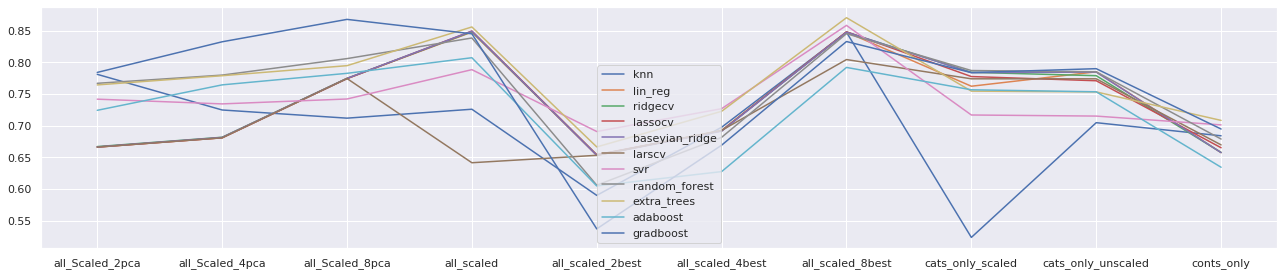

In [36]:
fig = pyplot.figure(1, (18,4))
for est in all_estimators:
    ax = pyplot.subplot(1,1,1)
    sns.lineplot(x='pipe', y=est, data=pipe_performance, axes=ax, label=est)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    pyplot.xlabel(None)
    pyplot.ylabel(None)
    pyplot.tight_layout()

### Hyperparameter Tunning

In [60]:
X_train = all_cols_scaler.fit_transform(df_train.iloc[:, :-1])
X_test = all_cols_scaler.transform(df_test.iloc[:, :-1])

rfr = ensemble.RandomForestRegressor(random_state=rng, n_jobs=-1)

rfg_param_grid = {    
    'n_estimators':[i for i in range(50,251,50)],
    'max_depth':range(4, 11),
    'min_samples_split': [i for i in range(8, 17, 2)],
    'max_leaf_nodes':[i for i in range(8,17,2)],
}

grid = model_selection.GridSearchCV(estimator=rfr, param_grid=rfg_param_grid, cv=5,
                                    refit=True, verbose=1, n_jobs=-1, scoring=None)

grid.fit(X_train, df_train.iloc[:, -1])

print('\nbest params-> {}'.format(grid.best_params_))
print('best score-> {}'.format(grid.best_score_))
print('test score -> {}'.format(grid.score(X_test, df_test.iloc[:, -1:])))

Fitting 5 folds for each of 875 candidates, totalling 4375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 4375 out of 4375 | elapsed:  7.5min finished



best params-> {'max_depth': 9, 'max_leaf_nodes': 16, 'min_samples_split': 14, 'n_estimators': 150}
best score-> 0.8424441575575214
test score -> 0.8337046883728707


In [65]:
grid_results_rfr_pipe4 = pd.DataFrame(grid.cv_results_)
grid_results_rfr_pipe4.sort_values('rank_test_score').reset_index(drop=True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.275090,0.046290,0.110168,0.010007,10,14,16,150,"{'max_depth': 10, 'max_leaf_nodes': 14, 'min_s...",0.788924,0.805554,0.815467,0.868161,0.808361,0.817324,0.026923,1
1,0.194373,0.024425,0.109104,0.011201,7,14,14,100,"{'max_depth': 7, 'max_leaf_nodes': 14, 'min_sa...",0.790875,0.806547,0.812889,0.869299,0.805212,0.817004,0.027177,2
2,0.323276,0.057536,0.117293,0.009565,7,16,16,150,"{'max_depth': 7, 'max_leaf_nodes': 16, 'min_sa...",0.781097,0.808587,0.819046,0.868998,0.806969,0.816973,0.028917,3
3,0.230352,0.042204,0.110254,0.011625,10,16,16,150,"{'max_depth': 10, 'max_leaf_nodes': 16, 'min_s...",0.784700,0.802101,0.819773,0.867368,0.809717,0.816755,0.027838,4
4,0.225048,0.050367,0.109441,0.002722,8,14,14,100,"{'max_depth': 8, 'max_leaf_nodes': 14, 'min_sa...",0.788329,0.809071,0.820512,0.866408,0.798246,0.816575,0.027187,5


In [63]:
allscaled_8best = Pipeline([
    ('scale_cols', all_cols_scaler),
    ('pca_2', decomposition.PCA(n_components=2)),
])

X_train = allscaled_8best.fit_transform(df_train.iloc[:, :-1])
X_test = allscaled_8best.transform(df_test.iloc[:, :-1])

rfr = ensemble.RandomForestRegressor(random_state=rng, n_jobs=-1)

rfg_param_grid = {    
    'n_estimators':[i for i in range(50,251,50)],
    'max_depth':range(4, 11),
    'min_samples_split': [i for i in range(8, 17, 2)],
    'max_leaf_nodes':[i for i in range(8,17,2)],
}

grid = model_selection.GridSearchCV(estimator=rfr, param_grid=rfg_param_grid, cv=5,
                                    refit=True, verbose=1, n_jobs=-1, scoring=None)

grid.fit(X_train, df_train.iloc[:, -1])

print('\nbest params-> {}'.format(grid.best_params_))
print('best score-> {}'.format(grid.best_score_))
print('test score -> {}'.format(grid.score(X_test, df_test.iloc[:, -1:])))

Fitting 5 folds for each of 875 candidates, totalling 4375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 4375 out of 4375 | elapsed:  6.7min finished



best params-> {'max_depth': 10, 'max_leaf_nodes': 14, 'min_samples_split': 16, 'n_estimators': 150}
best score-> 0.8173237996929725
test score -> 0.7576346050914671


(875, 17)

In [66]:
grid_results_rfr_pipe7 = pd.DataFrame(grid.cv_results_)
grid_results_rfr_pipe7.sort_values('rank_test_score').reset_index(drop=True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.275090,0.046290,0.110168,0.010007,10,14,16,150,"{'max_depth': 10, 'max_leaf_nodes': 14, 'min_s...",0.788924,0.805554,0.815467,0.868161,0.808361,0.817324,0.026923,1
1,0.194373,0.024425,0.109104,0.011201,7,14,14,100,"{'max_depth': 7, 'max_leaf_nodes': 14, 'min_sa...",0.790875,0.806547,0.812889,0.869299,0.805212,0.817004,0.027177,2
2,0.323276,0.057536,0.117293,0.009565,7,16,16,150,"{'max_depth': 7, 'max_leaf_nodes': 16, 'min_sa...",0.781097,0.808587,0.819046,0.868998,0.806969,0.816973,0.028917,3
3,0.230352,0.042204,0.110254,0.011625,10,16,16,150,"{'max_depth': 10, 'max_leaf_nodes': 16, 'min_s...",0.784700,0.802101,0.819773,0.867368,0.809717,0.816755,0.027838,4
4,0.225048,0.050367,0.109441,0.002722,8,14,14,100,"{'max_depth': 8, 'max_leaf_nodes': 14, 'min_sa...",0.788329,0.809071,0.820512,0.866408,0.798246,0.816575,0.027187,5


In [67]:
X_train = all_cols_scaler.fit_transform(df_train.iloc[:, :-1])
X_test = all_cols_scaler.transform(df_test.iloc[:, :-1])

etr = ensemble.ExtraTreesRegressor(random_state=rng, n_jobs=-1)

etr_param_grid = {
    'n_estimators':[i for i in range(50,201,50)],
    'max_depth':range(4, 9),
    'min_samples_split': [i for i in range(8, 17, 2)],
    'max_leaf_nodes':[i for i in range(8,15,2)],
}

grid = model_selection.GridSearchCV(estimator=etr, param_grid=etr_param_grid, cv=5,
                                    refit=True, verbose=1, n_jobs=-1, scoring=None)

grid.fit(X_train, df_train.iloc[:, -1])

print('\nbest params-> {}'.format(grid.best_params_))
print('best score-> {}'.format(grid.best_score_))
print('test score -> {}'.format(grid.score(X_test, df_test.iloc[:, -1:])))

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  2.9min finished



best params-> {'max_depth': 5, 'max_leaf_nodes': 14, 'min_samples_split': 16, 'n_estimators': 100}
best score-> 0.8438669286889376
test score -> 0.852854857010569


In [68]:
grid_results_etr_pipe7 = pd.DataFrame(grid.cv_results_)
grid_results_etr_pipe7.sort_values('rank_test_score').reset_index(drop=True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.209504,0.021974,0.103516,0.000201,5,14,16,100,"{'max_depth': 5, 'max_leaf_nodes': 14, 'min_sa...",0.840562,0.842136,0.801208,0.895070,0.840298,0.843867,0.029944,1
1,0.143854,0.033610,0.105600,0.001012,4,14,14,50,"{'max_depth': 4, 'max_leaf_nodes': 14, 'min_sa...",0.843670,0.839620,0.804501,0.888176,0.836780,0.842569,0.026774,2
2,0.285000,0.062261,0.137232,0.037944,7,14,16,200,"{'max_depth': 7, 'max_leaf_nodes': 14, 'min_sa...",0.834032,0.844743,0.799080,0.894917,0.837279,0.842026,0.030826,3
3,0.133373,0.007615,0.105334,0.002257,5,14,14,50,"{'max_depth': 5, 'max_leaf_nodes': 14, 'min_sa...",0.833748,0.848485,0.793724,0.891609,0.841896,0.841892,0.031364,4
4,0.206485,0.014651,0.105115,0.001024,8,14,10,100,"{'max_depth': 8, 'max_leaf_nodes': 14, 'min_sa...",0.836356,0.836909,0.802128,0.892519,0.838692,0.841330,0.029060,5


In [70]:
X_train = all_cols_scaler.fit_transform(df_train.iloc[:, :-1])
X_test = all_cols_scaler.transform(df_test.iloc[:, :-1])

gbr = ensemble.GradientBoostingRegressor(random_state=rng)

gbr_param_grid = {    
    'n_estimators':[i for i in range(50,201,50)],
    'max_depth':range(4, 9),
    'min_samples_split': [i for i in range(8, 17, 2)],
    'max_leaf_nodes':[i for i in range(8,15,2)],
}

grid = model_selection.GridSearchCV(estimator=gbr, param_grid=gbr_param_grid, cv=5,
                                    refit=True, verbose=1, n_jobs=-1, scoring=None)

grid.fit(X_train, df_train.iloc[:, -1])

print('\nbest params-> {}'.format(grid.best_params_))
print('best score-> {}'.format(grid.best_score_))
print('test score -> {}'.format(grid.score(X_test, df_test.iloc[:, -1:])))

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  1.3min



best params-> {'max_depth': 6, 'max_leaf_nodes': 14, 'min_samples_split': 8, 'n_estimators': 50}
best score-> 0.8611318926385878
test score -> 0.8660974129260512


[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.5min finished


In [71]:
grid_results_gbr_pipe7 = pd.DataFrame(grid.cv_results_)
grid_results_gbr_pipe7.sort_values('rank_test_score').reset_index(drop=True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.077789,0.001211,0.001633,0.000020,6,14,8,50,"{'max_depth': 6, 'max_leaf_nodes': 14, 'min_sa...",0.815622,0.839263,0.867242,0.895594,0.888401,0.861132,0.030069,1
1,0.141420,0.001033,0.001825,0.000033,6,14,8,100,"{'max_depth': 6, 'max_leaf_nodes': 14, 'min_sa...",0.818182,0.838372,0.866321,0.896679,0.881947,0.860226,0.028597,2
2,0.061345,0.000701,0.001624,0.000022,7,8,10,50,"{'max_depth': 7, 'max_leaf_nodes': 8, 'min_sam...",0.831868,0.823497,0.873804,0.889932,0.880299,0.859810,0.026935,3
3,0.068700,0.004568,0.001750,0.000138,8,8,10,50,"{'max_depth': 8, 'max_leaf_nodes': 8, 'min_sam...",0.830633,0.823640,0.874124,0.889932,0.880532,0.859702,0.027227,4
4,0.088105,0.005567,0.001706,0.000110,8,14,12,50,"{'max_depth': 8, 'max_leaf_nodes': 14, 'min_sa...",0.822357,0.822908,0.861736,0.905102,0.886341,0.859598,0.033257,5
